# FluxInfer Anomaly Detection

In [3]:
import numpy as np
import sklearn.mixture
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from tsdr import tsdr
from tsdr.testseries import sockshop
import math

In [2]:
import random

def fluxinfer_smooth(x: np.ndarray) -> tuple[np.ndarray, list[np.ndarray], np.ndarray]:
    x_: np.ndarray = np.copy(x)
    while True:
        reshaped_x = x_.reshape(-1, 1)
        labels = sklearn.mixture.GaussianMixture(n_components=2).fit(reshaped_x).predict(reshaped_x)
        seg_bounds: np.ndarray = np.argwhere(np.abs(np.diff(labels)) == 1).flatten() + 1  # Calculate segmentation boundaries.
        segs: list[np.ndarray] = np.split(x_, indices_or_sections=seg_bounds)
        k: int = len(segs)
        if k <= 2:
            return x_, segs, seg_bounds
            
        global_i = len(segs[0])
        changed = False
        for j in range(1, len(segs)-1):  # skip the first and last segment
            if len(segs[j]) < len(segs[j+1]):
                for i in range(len(segs[j])):
                    v = random.choice(list(segs[j+1]))
                    segs[j][i], x_[global_i+i] = v, v
                    changed = True
            global_i += len(segs[j])
                    
        if changed:
            x = x_
        else:
            return x_, segs, seg_bounds

def fluxinfer_detect_anomaly(x: np.ndarray) -> bool:
    smoothed_x, segs, seg_bounds = fluxinfer_smooth(x)
    k = len(segs)
    if k == 0:
        return False
    mean_k2, std_k2 = np.mean(segs[k-2]), np.std(segs[k-2])
    if std_k2 == 0:
        return False
    zscores = np.frompyfunc(lambda x: (x - mean_k2) / std_k2, 1, 1)(segs[k-1])
    return np.abs(np.mean(zscores)) > 3*np.std(zscores)


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


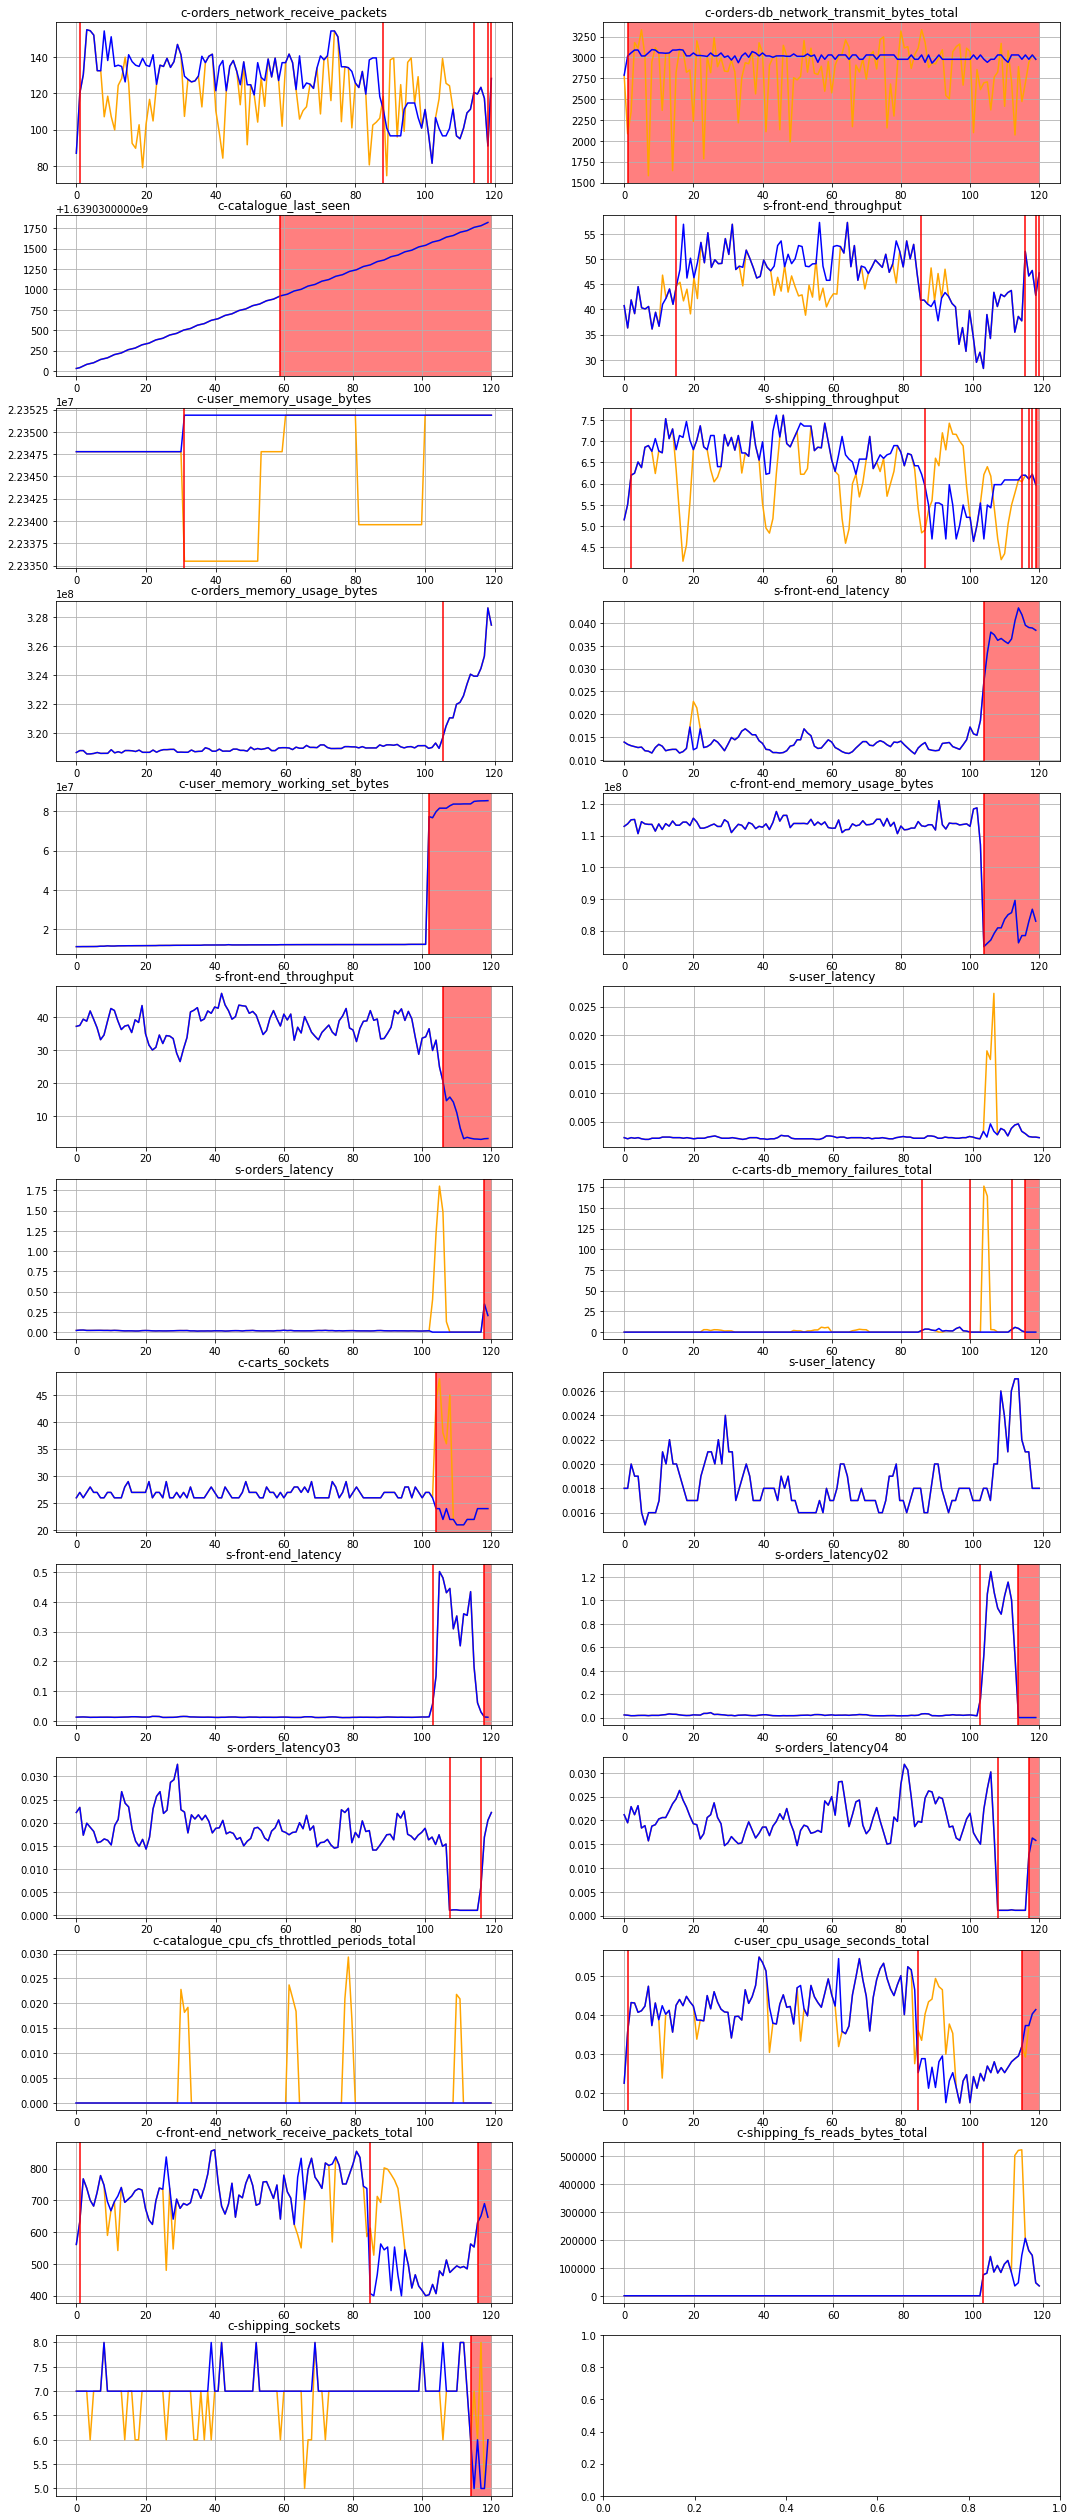

In [9]:
cases = sockshop.testcases_of_sockshop
ncols = 2
nrows = math.ceil(len(cases)/ncols)
fig, axs = plt.subplots(nrows, ncols=ncols)
fig.set_size_inches(18, 4.0*nrows)
for case, ax in zip(cases, axs.flatten()):
    # if case['name'] != 'c-orders_memory_usage_bytes':
    #     continue
    ts = np.array(case['datapoints'])
    smoothed_x, segs, seg_bounds = fluxinfer_smooth(ts)
    is_anomaly: bool = fluxinfer_detect_anomaly(ts)
    ax.grid()
    ax.set_title(case['name'])
    ax.plot(case['datapoints'], color='orange')
    ax.plot(smoothed_x, color='blue')
    for bound in seg_bounds:
        ax.axvline(bound, color='r')
    if is_anomaly:
        ax.axvspan(seg_bounds[-1], len(ts), color='red', alpha=0.5)